# Quantize a Stable Diffusion Model with OpenVINO

This notebook shows how to quantize a diffusion model with OpenVINO's [Neural Network Compression Framework](https://github.com/openvinotoolkit/nncf) (NNCF).

With quantization, we reduce the precision of the model's weights and activations from floating point (FP32) to integer (INT8). This results in a smaller model with faster inference times with OpenVINO Runtime.

Traditional optimization methods like post-training 8-bit quantization do not work well for Stable Diffusion models and can lead to poor generation results. On the other hand, weight compression does not improve performance significantly when applied to Stable Diffusion models, as the size of activations is comparable to weights. The UNet model takes up most of the overall execution time of the pipeline. Thus, optimizing just one model brings substantial benefits in terms of inference speed while keeping acceptable accuracy without fine-tuning. Quantizing the rest of the diffusion pipeline does not significantly improve inference performance but could potentially lead to substantial degradation of accuracy.

Therefore, the proposal is to apply quantization in *hybrid mode* for the UNet model and weight-only quantization for the rest of the pipeline components. The hybrid mode involves the quantization of weights in MatMul and Embedding layers, and activations of other layers, facilitating accuracy preservation post-optimization while reducing the model size.
For more details refers to [documentation](https://github.com/huggingface/optimum-intel/blob/main/docs/source/optimization_ov.mdx).

The notebook demonstrates post-training quantization in *hybrid mode*, which does not require specific hardware to execute. A laptop or desktop with a recent Intel Core processor is recommended for best results. To install the requirements for this notebook, please do `pip install -r requirements.txt` or uncomment the cell below to install the requirements in your current Python environment.

In [2]:
# %pip install "optimum-intel[openvino]" datasets ipywidgets

In [ ]:
import time
import datasets
import matplotlib.pyplot as plt
import numpy as np
import transformers
from pathlib import Path
from openvino.runtime import Core
from optimum.intel import OVConfig, OVQuantizer, OVStableDiffusionPipeline, OVWeightQuantizationConfig
from optimum.intel.openvino.quantization.configuration import OVQuantizationMethod

transformers.logging.set_verbosity_error()
datasets.logging.set_verbosity_error()

## Settings

For this tutorial, we use the [jxie/coco_captions](https://huggingface.co/datasets/jxie/coco_captions), dataset contains over 120,000 images, each annotated with multiple captions describing the objects and activities depicted in the image. The notebook was tested with the [stabilityai/stable-diffusion-2-1](https://huggingface.co/stabilityai/stable-diffusion-2-1) model. Other [stable diffusion models](https://huggingface.co/models?pipeline_tag=text-to-image) for text-to-image generation should also work.

In [4]:
MODEL_ID = "stabilityai/stable-diffusion-2-1"
DATASET_NAME = "jxie/coco_captions"

base_model_path = Path(f"models/{MODEL_ID}")
fp32_model_path = base_model_path.with_name(base_model_path.name + "_FP32")
int8_model_path = base_model_path.with_name(base_model_path.name + "_INT8")

## Post-training Hybrid Quantization

To perform post-training optimization on the `OVStableDiffusionPipeline`, you need to provide the `quantization_config` to the `from_pretrained` method.
The `quantization_config` is utilized to define optimization parameters for optimizing the Stable Diffusion pipeline. To enable hybrid quantization, specify the quantization dataset in the `quantization_config`. Otherwise, weight-only quantization to a specified data type (8 or 4 bits) is applied to UNet model.
That's all!

### Prepare the Dataset

We need a small representative calibration dataset to quantize the model. For text-to-image generation we should collect text descriptions or prompts that provide information about the desired image. The `COCO Captions` dataset primarily consists of images paired with multiple human-generated captions describing the contents of the image. Thus, we'll take the `caption` column, which contains descriptions corresponding to the images, as our calibration data.

The `datasets` library makes it easy to load datasets. Common datasets can be loaded from the Hugging Face Hub by providing the name of the dataset. See https://github.com/huggingface/datasets. We can load the `jxie/coco_captions` dataset with `load_dataset` and show a random dataset item.

In [5]:
dataset = datasets.load_dataset(DATASET_NAME, split="train", streaming=True).shuffle(seed=42)
print(next(iter(dataset)))

Resolving data files:   0%|          | 0/182 [00:00<?, ?it/s]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=640x480 at 0x7FC5721034D0>, 'filename': 'COCO_train2014_000000494175.jpg', 'cocoid': 494175, 'caption': 'A crowded arena filled with people and confetti.'}


In [6]:
def preprocess_fn(example):
    return {"prompt": example["caption"]}

NUM_SAMPLES = 200
dataset = dataset.take(NUM_SAMPLES)
calibration_dataset = dataset.map(lambda x: preprocess_fn(x), remove_columns=dataset.column_names)

### Quantize the Model

We load the model from the Hugging Face Hub. The model will be automatically downloaded if it has not been downloaded before, or loaded from the cache otherwise.

In [7]:
int8_pipe = OVStableDiffusionPipeline.from_pretrained(model_id=MODEL_ID, export=True)
quantization_config = OVWeightQuantizationConfig(bits=8, num_samples=NUM_SAMPLES, quant_method=OVQuantizationMethod.HYBRID)
quantizer = OVQuantizer(int8_pipe)
quantizer.quantize(
    ov_config=OVConfig(quantization_config=quantization_config),
    calibration_dataset=calibration_dataset,
    save_directory=int8_model_path
)

Keyword arguments {'subfolder': '', 'trust_remote_code': False} are not expected by StableDiffusionPipeline and will be ignored.


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

/home/ltalamanova/tmp_venv/lib/python3.11/site-packages/transformers/modeling_attn_mask_utils.py:88: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if input_shape[-1] > 1 or self.sliding_window is not None:
/home/ltalamanova/tmp_venv/lib/python3.11/site-packages/transformers/modeling_attn_mask_utils.py:164: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if past_key_values_length > 0:
/home/ltalamanova/tmp_venv/lib/python3.11/site-packages/diffusers/models/unets/unet_2d_condition.py:1249: TracerWarning: Converting a tensor to a Python boolean might cause 

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

INFO:nncf:Statistics of the bitwidth distribution:
┍━━━━━━━━━━━━━━━━━━━━━━━━━━━┯━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┯━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┑
│ Weight compression mode   │ % all parameters (layers)   │ % ratio-defining parameters (layers)   │
┝━━━━━━━━━━━━━━━━━━━━━━━━━━━┿━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┿━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┥
│ int8_asym                 │ 100% (32 / 32)              │ 100% (32 / 32)                         │
┕━━━━━━━━━━━━━━━━━━━━━━━━━━━┷━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┷━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┙


Output()

INFO:nncf:Statistics of the bitwidth distribution:
┍━━━━━━━━━━━━━━━━━━━━━━━━━━━┯━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┯━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┑
│ Weight compression mode   │ % all parameters (layers)   │ % ratio-defining parameters (layers)   │
┝━━━━━━━━━━━━━━━━━━━━━━━━━━━┿━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┿━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┥
│ int8_asym                 │ 100% (40 / 40)              │ 100% (40 / 40)                         │
┕━━━━━━━━━━━━━━━━━━━━━━━━━━━┷━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┷━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┙


Output()

INFO:nncf:Statistics of the bitwidth distribution:
┍━━━━━━━━━━━━━━━━━━━━━━━━━━━┯━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┯━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┑
│ Weight compression mode   │ % all parameters (layers)   │ % ratio-defining parameters (layers)   │
┝━━━━━━━━━━━━━━━━━━━━━━━━━━━┿━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┿━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┥
│ int8_asym                 │ 100% (140 / 140)            │ 100% (140 / 140)                       │
┕━━━━━━━━━━━━━━━━━━━━━━━━━━━┷━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┷━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┙


Output()

INFO:nncf:66 ignored nodes were found by types in the NNCFGraph
INFO:nncf:66 ignored nodes were found by types in the NNCFGraph
INFO:nncf:Statistics of the bitwidth distribution:
┍━━━━━━━━━━━━━━━━━━━━━━━━━━━┯━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┯━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┑
│ Weight compression mode   │ % all parameters (layers)   │ % ratio-defining parameters (layers)   │
┝━━━━━━━━━━━━━━━━━━━━━━━━━━━┿━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┿━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┥
│ int8_asym                 │ 100% (216 / 216)            │ 100% (216 / 216)                       │
┕━━━━━━━━━━━━━━━━━━━━━━━━━━━┷━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┷━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┙


Output()

INFO:nncf:216 ignored nodes were found by names in the NNCFGraph
INFO:nncf:Not adding activation input quantizer for operation: 10 __module.down_blocks.1.attentions.0.transformer_blocks.0.attn2.to_k/aten::linear/MatMul
INFO:nncf:Not adding activation input quantizer for operation: 11 __module.down_blocks.1.attentions.0.transformer_blocks.0.attn2.to_v/aten::linear/MatMul
INFO:nncf:Not adding activation input quantizer for operation: 12 __module.down_blocks.1.attentions.1.transformer_blocks.0.attn2.to_k/aten::linear/MatMul
INFO:nncf:Not adding activation input quantizer for operation: 13 __module.down_blocks.1.attentions.1.transformer_blocks.0.attn2.to_v/aten::linear/MatMul
INFO:nncf:Not adding activation input quantizer for operation: 14 __module.down_blocks.2.attentions.0.transformer_blocks.0.attn2.to_k/aten::linear/MatMul
INFO:nncf:Not adding activation input quantizer for operation: 15 __module.down_blocks.2.attentions.0.transformer_blocks.0.attn2.to_v/aten::linear/MatMul
INFO:nncf:N

Output()

Output()

## Compare INT8 and FP32 models

We create two pipelines: `int8_pipe` and `fp32_pipe` to compare the FP32 and INT8 OpenVINO models. These pipelines will be used for benchmarking later in this notebook.

In [8]:
fp32_pipe = OVStableDiffusionPipeline.from_pretrained(model_id=MODEL_ID, export=True)
fp32_pipe.save_pretrained(fp32_model_path)

Keyword arguments {'subfolder': '', 'trust_remote_code': False} are not expected by StableDiffusionPipeline and will be ignored.


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

/home/ltalamanova/tmp_venv/lib/python3.11/site-packages/transformers/modeling_attn_mask_utils.py:88: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if input_shape[-1] > 1 or self.sliding_window is not None:
/home/ltalamanova/tmp_venv/lib/python3.11/site-packages/transformers/modeling_attn_mask_utils.py:164: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if past_key_values_length > 0:
/home/ltalamanova/tmp_venv/lib/python3.11/site-packages/diffusers/models/unets/unet_2d_condition.py:1249: TracerWarning: Converting a tensor to a Python boolean might cause 

### Visual Accuracy
Let us check predictions between the original and optimized pipelines using the same prompt.

In [9]:
def visualize_results(fp32_img, int8_img):
    im_w, im_h = fp32_img.size
    is_horizontal = im_h <= im_w
    figsize = (20, 30) if is_horizontal else (30, 20)
    fig, axs = plt.subplots(1 if is_horizontal else 2, 2 if is_horizontal else 1, figsize=figsize, sharex='all', sharey='all')
    fig.patch.set_facecolor('white')
    list_axes = list(axs.flat)
    for a in list_axes:
        a.set_xticklabels([])
        a.set_yticklabels([])
        a.get_xaxis().set_visible(False)
        a.get_yaxis().set_visible(False)
        a.grid(False)
    list_axes[0].imshow(np.array(fp32_img))
    list_axes[1].imshow(np.array(int8_img))
    img1_title = "FP32 result"
    img2_title = "INT8 result"
    list_axes[0].set_title(img1_title, fontsize=20)
    list_axes[1].set_title(img2_title, fontsize=20)
    fig.subplots_adjust(wspace=0.0 if is_horizontal else 0.01 , hspace=0.01 if is_horizontal else 0.0)
    fig.tight_layout()

In [10]:
prompt = "Self-portrait oil painting, a beautiful cyborg with golden hair, 8k"

def generate_image(pipeline, prompt):
    transformers.set_seed(1)
    return pipeline(
        prompt=prompt,
        guidance_scale=8.0,
        output_type="pil"
    ).images[0]

In [11]:
fp32_img = generate_image(fp32_pipe, prompt)
int8_img = generate_image(int8_pipe, prompt)

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

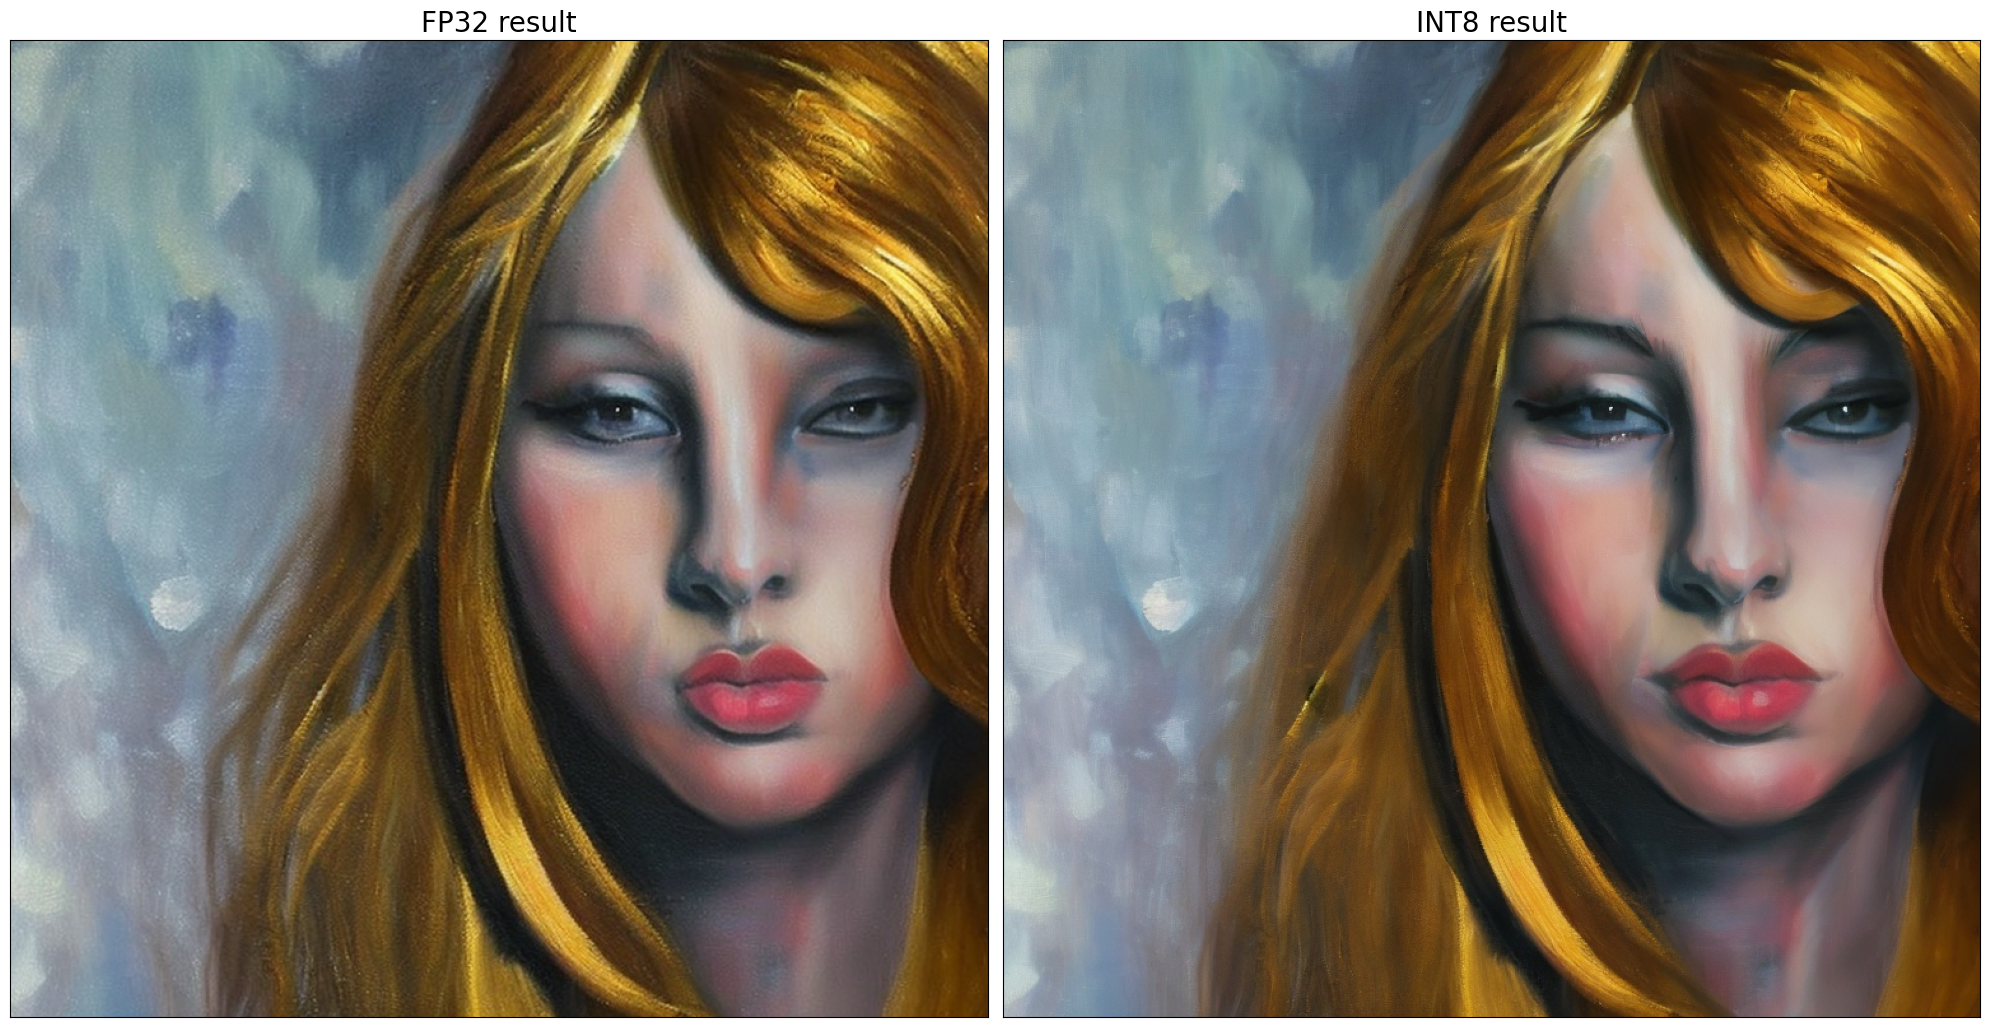

In [12]:
visualize_results(fp32_img, int8_img)

### Model Size

We save the FP32 PyTorch model and define a function to show the model size for the PyTorch and OpenVINO models.

In [13]:
def get_model_size(model_folder, framework):
    """
    Return OpenVINO or PyTorch model size in Mb.
    
    Arguments:
        model_folder:
            Directory containing a model.
        framework:
            Define whether the model is a PyTorch or an OpenVINO model.
    """
    model_size = 0
    if framework.lower() == "openvino":
        for model_path in Path(model_folder).rglob("*.xml"):
            model_size += model_path.stat().st_size

    extension = "*.bin" if framework.lower() == "openvino" else "*.safetensors"
    for model_path in Path(model_folder).rglob(extension):
        model_size += model_path.stat().st_size
    model_size /= 2**20
    return model_size

In [14]:
fp32_model_size = get_model_size(fp32_model_path, "openvino")
int8_model_size = get_model_size(int8_model_path, "openvino")
print(f"FP32 model size: {fp32_model_size:.2f} MB")
print(f"INT8 model size: {int8_model_size:.2f} MB")
print(f"INT8 size decrease: {fp32_model_size / int8_model_size:.2f}x")

FP32 model size: 4923.07 MB
INT8 model size: 1238.31 MB
INT8 size decrease: 3.98x


### Latency

Compare the inference speed of the quantized OpenVINO model with that of the original PyTorch model.

This benchmark provides an estimate of performance, but keep in mind that other programs running on the computer, as well as power management settings, can affect performance.

In [15]:
def get_val_dataset(num_items=3):
    return [item["caption"] for item in dataset.take(num_items)]

def benchmark(pipeline, dataset):
    """
    Benchmark PyTorch or OpenVINO model. This function does inference on `num_items`
    dataset items and returns the median latency in milliseconds
    """
    latencies = []
    for prompt in dataset:
        start_time = time.perf_counter()
        _ = pipeline(prompt=prompt)
        end_time = time.perf_counter()
        latencies.append(end_time - start_time)
    return np.median(latencies) * 1000


cpu_device_name = Core().get_property("CPU", "FULL_DEVICE_NAME")
print(cpu_device_name)

val_subset = get_val_dataset()
original_latency = benchmark(fp32_pipe, val_subset)
print(f"Latency of original FP32 model: {original_latency:.2f} ms")

quantized_latency = benchmark(int8_pipe, val_subset)
print(f"Latency of quantized model: {quantized_latency:.2f} ms")
print(f"Speedup: {(original_latency/quantized_latency):.2f}x")

Intel(R) Core(TM) i9-10980XE CPU @ 3.00GHz


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Latency of original FP32 model: 180307.04 ms


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Latency of quantized model: 154601.10 ms
Speedup: 1.17x
